In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')

train.shape, test.shape, submission.shape

((8932, 12), (3828, 11), (3828, 2))

In [2]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [3]:
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [4]:
def con_period(x):
    if x == 'Dec 31, 2018' :
        return '2019'
    elif x == 'Jun 30, 2020' :
        return '2020.5'
    elif x == 'Jun 30, 2019' :
        return '2019.5'
    elif x == 'May 31, 2020' :
        return '2020.3333'
    elif x == 'May 31, 2019' :
        return '2019.3333'
    elif x == 'Jan 31, 2019' :
        return '2019.0833'
    elif x == 'Jan 1, 2019' :
        return '2019'
    elif x == 'Jan 12, 2019' :
        return '2019.034'
    elif x == 'Dec 31, 2019' :
        return '2020'
    elif x == 'Jun 1, 2019' :
        return '2019.416'
    else :
        return x

In [5]:
train['contract'] = 2018
test['contract'] = 2018

In [6]:
train['contract_until'] = train['contract_until'].apply(con_period).astype('float64')
test['contract_until'] = test['contract_until'].apply(con_period).astype('float64')

In [7]:
train['contract_until'] -= train['contract']
test['contract_until'] -= test['contract']

In [8]:
train.drop('contract', axis = 1, inplace = True)
test.drop('contract', axis = 1, inplace = True)

In [9]:
X = train.drop(['id', 'name'], axis = 1)
test = test.drop(['id', 'name'], axis = 1)

In [10]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['continent', 'position', 'prefer_foot']
numeric_features = ['age', 'contract_until', 'reputation', 'stat_overall', 'stat_potential',
       'stat_skill_moves']

In [11]:
print(categorical_features)
print(numeric_features)

['continent', 'position', 'prefer_foot']
['age', 'contract_until', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


In [12]:
for obj in categorical_features:
    le = LabelEncoder()
    X[obj] = le.fit_transform(X[obj])
    test[obj] = le.transform(test[obj])

In [13]:
from sklearn.preprocessing import StandardScaler

for obj in numeric_features:
    sc = StandardScaler()
    X[obj] = sc.fit_transform(X[[obj]])
    test[obj] = sc.fit_transform(test[[obj]])

In [14]:
from pycaret.regression import *

In [17]:
clf = setup(data = X, target = 'value', session_id = 123)

,Description,Value
0,session_id,123
1,Target,value
2,Original Data,"(8932, 10)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6252, 16)"


In [18]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.445e+05,5.939e+11,6.146e+05,0.8864,0.1317,0.0748,1.309
gbr,Gradient Boosting Regressor,2.5e+05,8.601e+11,8.314e+05,0.9785,0.3324,0.2299,0.147
xgboost,Extreme Gradient Boosting,1.833e+05,1.033e+12,8.86e+05,0.9757,0.1371,0.0728,0.651
et,Extra Trees Regressor,1.902e+05,1.149e+12,9.129e+05,0.9726,0.1155,0.0605,0.457
rf,Random Forest Regressor,2.051e+05,1.254e+12,9.71e+05,0.9696,0.1107,0.0624,0.426
lightgbm,Light Gradient Boosting Machine,2.013e+05,1.324e+12,9.923e+05,0.9675,0.1902,0.1199,0.045
dt,Decision Tree Regressor,2.745e+05,2.209e+12,1.373e+06,0.9417,0.1447,0.0713,0.015
ada,AdaBoost Regressor,1.707e+06,4.744e+12,2.148e+06,0.8652,1.54,4.967,0.105
knn,K Neighbors Regressor,7.314e+05,5.731e+12,2.3e+06,0.8538,0.3475,0.3012,0.033
br,Bayesian Ridge,1.95e+06,1.289e+13,3.548e+06,0.6517,1.359,5.25,0.007


In [19]:
cat = create_model('catboost', cross_validation = False)
gbr = create_model('gbr', cross_validation = False)
xgb = create_model('xgboost', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,140524.125,2.735426e+11,523013.03125,0.9901,0.1263,0.0652


In [20]:
tune_cat = tune_model(cat, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.126e+05,7.447e+11,8.63e+05,0.9833,0.3172,0.2191
1,2.991e+05,4.648e+11,6.818e+05,0.9899,0.3696,0.2744
2,2.718e+05,4.5e+11,6.708e+05,0.9811,0.3184,0.2504
3,2.393e+05,3.325e+11,5.767e+05,0.9859,0.3402,0.244
4,2.535e+05,2.179e+11,4.668e+05,0.9915,0.3204,0.2441
5,3.298e+05,2.3e+12,1.517e+06,0.9528,0.306,0.2208
6,3.785e+05,1.839e+12,1.356e+06,0.9566,0.4314,0.2766
7,2.888e+05,6.836e+11,8.268e+05,0.9768,0.3183,0.2364
8,3.391e+05,6.99e+11,8.361e+05,0.9848,0.369,0.2869
9,2.782e+05,5.587e+11,7.475e+05,0.9851,0.3816,0.2789


In [21]:
tune_gbr = tune_model(gbr, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.476e+05,1.819e+11,4.265e+05,0.9959,0.0964,0.0585
1,1.797e+05,4.667e+11,6.831e+05,0.9898,0.1365,0.0756
2,1.38e+05,3.17e+11,5.63e+05,0.9867,0.122,0.0705
3,1.246e+05,2.056e+11,4.534e+05,0.9913,0.1357,0.0775
4,1.256e+05,1.301e+11,3.607e+05,0.9949,0.1021,0.0677
5,2.087e+05,2.233e+12,1.494e+06,0.9542,0.1155,0.0615
6,2.539e+05,2.244e+12,1.498e+06,0.947,0.1439,0.0705
7,1.659e+05,3.455e+11,5.878e+05,0.9883,0.095,0.0612
8,2.17e+05,1.119e+12,1.058e+06,0.9757,0.1164,0.0698
9,1.198e+05,1.547e+11,3.933e+05,0.9959,0.1223,0.0784


In [22]:
tune_xgb = tune_model(xgb, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.676e+05,3.776e+11,6.145e+05,0.9916,0.1066,0.0683
1,1.612e+05,2.68e+11,5.177e+05,0.9942,0.1084,0.0634
2,1.417e+05,2.296e+11,4.791e+05,0.9903,0.1373,0.0706
3,1.294e+05,1.68e+11,4.098e+05,0.9929,0.1304,0.0742
4,1.232e+05,1.327e+11,3.643e+05,0.9948,0.096,0.0644
5,2.186e+05,2.083e+12,1.443e+06,0.9573,0.0905,0.0595
6,2.609e+05,2.999e+12,1.732e+06,0.9292,0.1353,0.0774
7,1.408e+05,2.502e+11,5.002e+05,0.9915,0.0967,0.0642
8,1.982e+05,5.759e+11,7.589e+05,0.9875,0.1205,0.0721
9,1.589e+05,4.525e+11,6.727e+05,0.988,0.1626,0.1012


In [23]:
blend_model = blend_models(estimator_list = [tune_cat, tune_gbr, tune_xgb], optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.83e+05,3.096e+11,5.565e+05,0.9931,0.1347,0.0969
1,1.808e+05,3.074e+11,5.545e+05,0.9933,0.1869,0.1182
2,1.371e+05,1.106e+11,3.326e+05,0.9953,0.1557,0.1059
3,1.31e+05,1.234e+11,3.513e+05,0.9948,0.1847,0.1113
4,1.415e+05,1.174e+11,3.427e+05,0.9954,0.1555,0.1066
5,2.275e+05,2.144e+12,1.464e+06,0.9561,0.151,0.0957
6,2.647e+05,2.166e+12,1.472e+06,0.9488,0.2039,0.1181
7,1.519e+05,1.953e+11,4.419e+05,0.9934,0.1373,0.0945
8,2.107e+05,5.257e+11,7.251e+05,0.9886,0.1741,0.1209
9,1.584e+05,2.779e+11,5.271e+05,0.9926,0.2271,0.1263


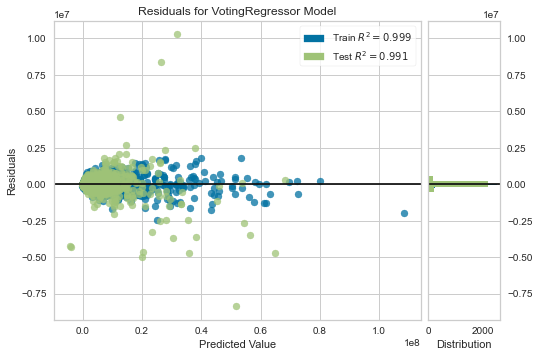

In [24]:
plot_model(blend_model)

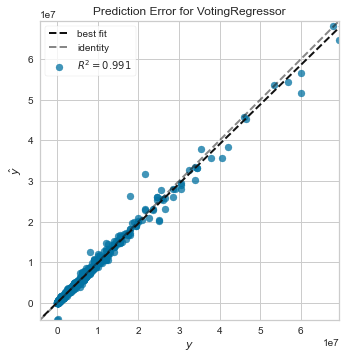

In [25]:
plot_model(blend_model, plot = 'error')

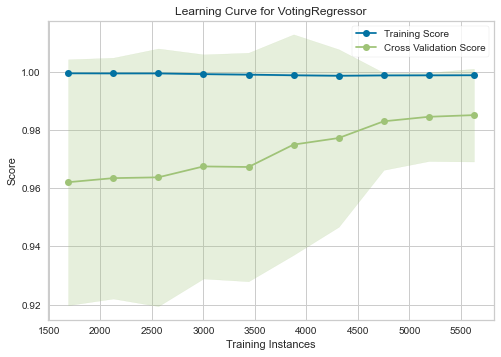

In [26]:
plot_model(blend_model, plot = 'learning')

In [27]:
final_model = finalize_model(blend_model)

In [28]:
pred = predict_model(final_model, data = test)

In [29]:
pred.head(3)

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,Label
0,1.664392,2,1.363659,3,1,8.599478,3.859778,3.569820,3.309849,8.008580e+07
1,0.151739,4,1.363659,3,1,8.599478,3.570255,3.406758,3.309849,9.316769e+07
2,0.367833,2,2.153395,2,1,6.369358,3.425494,3.243695,2.029524,7.706475e+07


In [31]:
submission['value'] = pred['Label']
submission

,id,value
0,1,8.008580e+07
1,2,9.316769e+07
2,4,7.706475e+07
3,5,7.765022e+07
4,6,5.993784e+07
...,...,...
3823,16924,1.070839e+05
3824,16929,3.808755e+04
3825,16932,7.182358e+04
3826,16937,8.888074e+04


In [32]:
submission.to_csv('Practice.csv', index = False)